# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

**Цели исследования** - проверка наличия свзей между возвратом кредита в срок и наличием детей, семейным положением, уровнем дохода и целью получения кредита.


## Знакомство с данными

In [1]:
# импорт библиотек
import pandas as pd 
from matplotlib import pyplot as plt 
pd.set_option("display.float_format", "{:.3f}".format)
import warnings
warnings.simplefilter('ignore')
import seaborn as sns
from nltk.stem import SnowballStemmer

In [2]:
df = pd.read_csv('../../yandex-praktikum-sources/bank-data.csv') # чтение файла с данными и сохранение в df

In [3]:
display(df.head(10)) # просмотр первых 10 строк
display(df.info()) # просмотр общей информации о данных
display(df.describe() )

children  days_employed  dob_years education  education_id  \
0         1      -8437.673         42    высшее             0   
1         1      -4024.804         36   среднее             1   
2         0      -5623.423         33   Среднее             1   
3         3      -4124.747         32   среднее             1   
4         0     340266.072         53   среднее             1   
5         0       -926.186         27    высшее             0   
6         0      -2879.202         43    высшее             0   
7         0       -152.780         50   СРЕДНЕЕ             1   
8         2      -6929.865         35    ВЫСШЕЕ             0   
9         0      -2188.756         41   среднее             1   

      family_status  family_status_id gender income_type  debt  total_income  \
0   женат / замужем                 0      F   сотрудник     0    253875.639   
1   женат / замужем                 0      F   сотрудник     0    112080.014   
2   женат / замужем                 0      M   сотрудник     0    145885.952   
3   женат / замужем                 0      M   сотрудник     0    267628.550   
4  гражданский брак                 1      F   пенсионер     0    158616.078   
5  гражданский брак                 1      M   компаньон     0    255763.565   
6   женат / замужем                 0      F   компаньон     0    240525.972   
7   женат / замужем                 0      M   сотрудник     0    135823.934   
8  гражданский брак                 1      F   сотрудник     0     95856.832   
9   женат / замужем                 0      M   сотрудник     0    144425.938   

                      purpose  
0               покупка жилья  
1     приобретение автомобиля  
2               покупка жилья  
3  дополнительное образование  
4             сыграть свадьбу  
5               покупка жилья  
6           операции с жильем  
7                 образование  
8       на проведение свадьбы  
9     покупка жилья для семьи

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


None

children  days_employed  dob_years  education_id  family_status_id  \
count 21525.000      19351.000  21525.000     21525.000         21525.000   
mean      0.539      63046.498     43.293         0.817             0.973   
std       1.382     140827.312     12.575         0.548             1.420   
min      -1.000     -18388.950      0.000         0.000             0.000   
25%       0.000      -2747.424     33.000         1.000             0.000   
50%       0.000      -1203.370     42.000         1.000             0.000   
75%       1.000       -291.096     53.000         1.000             1.000   
max      20.000     401755.400     75.000         4.000             4.000   

           debt  total_income  
count 21525.000     19351.000  
mean      0.081    167422.302  
std       0.273    102971.566  
min       0.000     20667.264  
25%       0.000    103053.153  
50%       0.000    145017.938  
75%       0.000    203435.068  
max       1.000   2265604.029

В таблице 12 столбцов. Согласно документации к данным:
* `children` — количество детей в семье
* `days_employed` — общий трудовой стаж в днях
* `dob_years` — возраст клиента в годах
* `education` — уровень образования клиента
* `education_id` — идентификатор уровня образования
* `family_status` — семейное положение
* `family_status_id` — идентификатор семейного положения
* `gender` — пол клиента
* `income_type` — тип занятости
* `debt` — имел ли задолженность по возврату кредитов
* `total_income` — ежемесячный доход
* `purpose` — цель получения кредита

В первых строках таблицы уже видно проблемы в данных:
1. В столбце `days_employed` присутствуют нули и отрицательные числа. Возможно, это связано с неверным заполнением анкет - перепутаны местами даты начала и окончания срока. Кроме того, величина трудового стажа в строке 4 больше 340 тысяч - в пересчете в года это более 930. Вероятно, при обработке данных произошла ошибка вычисления времени, и это значение в часах. Это придется исправить.

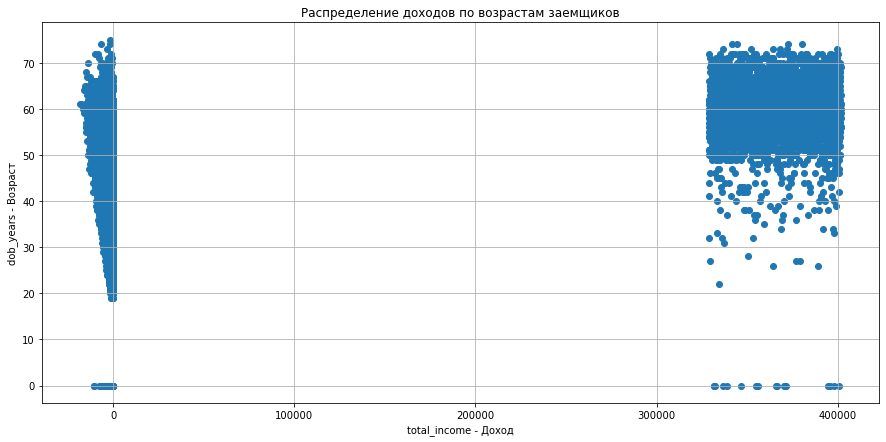

In [4]:
# покажем графиком, что это так
plt.figure(figsize=(15,7))
plt.scatter(df.days_employed, df.dob_years)
plt.xlabel('total_income - Доход') # названия осей
plt.ylabel('dob_years - Возраст')
plt.title('Распределение доходов по возрастам заемщиков')
plt.grid()
plt.show()

2. Значения столбца `education` не приведены к единому стилю, что затруднит категоризацию:

In [5]:
# выведем уникальные значения столбца education
df.education.unique() 

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

3. Есть пропуски в данных в столбцах `days_employed` и `total_income`, причем количество пропусков совпадает - пока сложно сказать, с чем это может быть связано. Возможно, эти соискатели никогда не работали и не имеют дохода? Это нужно проверить.
4. Цели получения кредита описаны не типовыми фразами, что затруднит категоризацию;
5. Среди возрастов людей есть нулевые значения (их видно как минимальные в выводе describe), в данном проекте мы заполним их.

**Вывод**

В каждой строке содержатся данные о потенциальном заемщике, которые описывают его с разных сторон.

В данных есть пропуски и отсутствует единообразие в текстовых данных. 

Чтобы двигаться дальше, нужно устранить проблемы в данных.

## Предобработка данных

### Обработка пропусков

#### Пропуски в стаже
По количествам данных в столбцах `days_employed` и `total_income` видно, что в них есть пропуски. Посмотрим на строки, в которых пропущен трудовой стаж:

In [6]:
df[df['days_employed'].isna()].head() # вывод первых 5 строк с пустым трудовым стажем

children  days_employed  dob_years education  education_id  \
12         0            nan         65   среднее             1   
26         0            nan         41   среднее             1   
29         0            nan         63   среднее             1   
41         0            nan         50   среднее             1   
55         0            nan         54   среднее             1   

            family_status  family_status_id gender  income_type  debt  \
12       гражданский брак                 1      M    пенсионер     0   
26        женат / замужем                 0      M  госслужащий     0   
29  Не женат / не замужем                 4      F    пенсионер     0   
41        женат / замужем                 0      F  госслужащий     0   
55       гражданский брак                 1      F    пенсионер     1   

    total_income                           purpose  
12           nan                   сыграть свадьбу  
26           nan                       образование  
29           nan  строительство жилой недвижимости  
41           nan  сделка с подержанным автомобилем  
55           nan                   сыграть свадьбу

В первых 5 строках наша гипотеза подтверждается - у людей без стажа нет и дохода. Убедимся в этом:

In [7]:
df[df['days_employed'].isna()].info() # общая информация о строках с пустым трудовым стажем

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2174 entries, 12 to 21510
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          2174 non-null   int64  
 1   days_employed     0 non-null      float64
 2   dob_years         2174 non-null   int64  
 3   education         2174 non-null   object 
 4   education_id      2174 non-null   int64  
 5   family_status     2174 non-null   object 
 6   family_status_id  2174 non-null   int64  
 7   gender            2174 non-null   object 
 8   income_type       2174 non-null   object 
 9   debt              2174 non-null   int64  
 10  total_income      0 non-null      float64
 11  purpose           2174 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 220.8+ KB


Действительно, из 2174 строк нет ни одного ненулевого значения дохода. Возможно, наша гипотеза верна и эти люди просто никогда не работали. Возможно, при сборе данных произошла ошибка или заемщики намеренно скрыли эти данные. Попробуем проверить это. 

In [8]:
df[df['days_employed'].isna()].groupby('income_type')['education'].count()

income_type
госслужащий         147
компаньон           508
пенсионер           413
предприниматель       1
сотрудник          1105
Name: education, dtype: int64

Среди строк с пустыми значениями ни одного безработного, так что дело все же в ошибке или намеренном сокрытии.
Так или иначе, эти пропуски нужно заполнить. Для восполнения данных о стаже можно посчитать, сколько человек мог проработать с 22 лет (возраст, в котором в основном заканчивают университет) до даты обращения в банк, а заработок рассчитать как медианный для его типа занятости и уровня образования. 

In [9]:
# заменяем пропуски в стаже рассчитанным значением
df['days_employed'] = df['days_employed'].fillna((df['dob_years'] - 22) * 365) 

# для всех видов занятости и уровней образования рассчитываем медианное значение заработка и заменяем ими NaN
df['total_income'] = df.groupby(['income_type', 'education_id'])['total_income'].apply(lambda x: x.fillna(x.median()))

df.isna().sum() # проверим, что пропусков не осталось

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

Конечно, такой способ очень приблизительный, а данные о трудовом стаже не используются в дальнейшем в исследовании. 
#### Отрицательные и экстремальные значения стажа
Мы уже убедились, что в данных о стаже есть проблемы, и дело не только в пропусках.  
В реальной жизни следовало бы уведомить инженера, ответственного за сбор данных о стаже, что эти данные собраны двумя разными, но одинаково некорректными способами - в тех строках, где результат имеется, он или отрицательный, или не в днях.
В данном проекте мы исправим это.<br>
Минусы у отрицательных значений отбросим, а экстремальные приведем к более реальным.<br>
При трудовом стаже в 50 лет и всех возможных надбавках и коэффициентах, стаж в днях не может быть более 50 тысяч дней. Эти значения примем за экстремальные - видимо, они подсчитаны в часах. Соответственно, поделим эти значения на 24.

In [10]:
# заменим все значения на их модули
df['days_employed'] = df['days_employed'].apply(abs)
# приведем значения в часах к дням  
df.loc[df['days_employed'] > 50000, 'days_employed'] = df.loc[df['days_employed'] > 50000, 'days_employed'] / 24

df.head(15)

children  days_employed  dob_years            education  education_id  \
0          1       8437.673         42               высшее             0   
1          1       4024.804         36              среднее             1   
2          0       5623.423         33              Среднее             1   
3          3       4124.747         32              среднее             1   
4          0      14177.753         53              среднее             1   
5          0        926.186         27               высшее             0   
6          0       2879.202         43               высшее             0   
7          0        152.780         50              СРЕДНЕЕ             1   
8          2       6929.865         35               ВЫСШЕЕ             0   
9          0       2188.756         41              среднее             1   
10         2       4171.484         36               высшее             0   
11         0        792.702         40              среднее             1   
12         0      15695.000         65              среднее             1   
13         0       1846.642         54  неоконченное высшее             2   
14         0       1844.956         56               высшее             0   

       family_status  family_status_id gender income_type  debt  total_income  \
0    женат / замужем                 0      F   сотрудник     0    253875.639   
1    женат / замужем                 0      F   сотрудник     0    112080.014   
2    женат / замужем                 0      M   сотрудник     0    145885.952   
3    женат / замужем                 0      M   сотрудник     0    267628.550   
4   гражданский брак                 1      F   пенсионер     0    158616.078   
5   гражданский брак                 1      M   компаньон     0    255763.565   
6    женат / замужем                 0      F   компаньон     0    240525.972   
7    женат / замужем                 0      M   сотрудник     0    135823.934   
8   гражданский брак                 1      F   сотрудник     0     95856.832   
9    женат / замужем                 0      M   сотрудник     0    144425.938   
10   женат / замужем                 0      M   компаньон     0    113943.491   
11   женат / замужем                 0      F   сотрудник     0     77069.234   
12  гражданский брак                 1      M   пенсионер     0    114842.854   
13   женат / замужем                 0      F   сотрудник     0    130458.229   
14  гражданский брак                 1      F   компаньон     1    165127.912   

                              purpose  
0                       покупка жилья  
1             приобретение автомобиля  
2                       покупка жилья  
3          дополнительное образование  
4                     сыграть свадьбу  
5                       покупка жилья  
6                   операции с жильем  
7                         образование  
8               на проведение свадьбы  
9             покупка жилья для семьи  
10               покупка недвижимости  
11  покупка коммерческой недвижимости  
12                    сыграть свадьбу  
13            приобретение автомобиля  
14         покупка жилой недвижимости

#### Отрицательные и экстремальные количества детей
Есть еще одна странность - существуют заемщики с 20 детьми и с отрицательным количеством детей.

In [11]:
print(df['children'].unique()) # сколько по-настоящему может быть детей в семье? 

[ 1  0  3  2 -1  4 20  5]


Поверить, что какие-то люди имеют по 20 детей и тем более -1 ребенка, сложно. К тому же нет, к примеру, 10 или 15 детей. Исправим это - минусы отбросим, а 20 заменим на 2. Скорее всего эти выбросы - ошибки ввода.

In [12]:
df['children'] = df['children'].apply(abs)
df['children'] = df['children'].replace(20, 2)

df['children'].unique() # проверим, что теперь значения больше похожи на настоящие

array([1, 0, 3, 2, 4, 5], dtype=int64)

#### Нулевые значения возраста
В данном проекте для простоты заменим нули медианным значением.

In [13]:
df['dob_years'] = df['dob_years'].replace(0, df['dob_years'].median())

df[df['dob_years'] == 0]['children'].count() # проверим, что нулей не осталось

0

**Вывод**

Пропущенные строки в столбцах `days_employed` и `total_income` заполнены, значения в столбце `days_employed` приведены к положительным величинам без экстремальных, детей в семьях от 0 до 5, а всем заемщикам больше 0 лет.

### Замена типа данных

Приведем значения в столбцах `days_employed` и `total_income` к целочисленным. Так как пустых значений в столбцах нет, метод `astype()` справится. 

In [14]:
df[['days_employed', 'total_income']] = df[['days_employed', 'total_income']].astype('int')

df.info() # проверим, что значения стали целочисленными

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21525 non-null  int64 
 1   days_employed     21525 non-null  int32 
 2   dob_years         21525 non-null  int64 
 3   education         21525 non-null  object
 4   education_id      21525 non-null  int64 
 5   family_status     21525 non-null  object
 6   family_status_id  21525 non-null  int64 
 7   gender            21525 non-null  object
 8   income_type       21525 non-null  object
 9   debt              21525 non-null  int64 
 10  total_income      21525 non-null  int32 
 11  purpose           21525 non-null  object
dtypes: int32(2), int64(5), object(5)
memory usage: 1.8+ MB


**Вывод**

Дробные значения дней в стаже и доходах не окажут особого влияния на результаты исследования, но работать с таблицей станет немного легче.

### Обработка дубликатов

Мы уже убедились, что в столбце `education` некоторые записи отличаются лишь регистром. Возможно, возникновение таких дублей вызвано разными шаблонами заполнения в разных филиалах банка. Перед удалением дубликатов избавимся от них.

In [15]:
df['education'].unique() # просмотр уникальных значений 

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

In [16]:
df['education'] = df['education'].str.lower() # приводим все записи к нижнему регистру

df['education'].unique() # контроль уникальных значений 

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

Подсчитаем количество явных дубликатов и удалим их.

In [17]:
df.duplicated().sum() # подсчёт явных дубликатов

71

In [18]:
df = df.drop_duplicates().reset_index(drop=True) # удаление явных дубликатов со сбросом индексов
df.duplicated().sum() # проверка на отсутствие дубликатов

0

**Вывод**

Явные дубликаты удалены, а неявные выявлены и тоже удалены.

### Стемминг

Для начала посмотрим, какие вообще цели получения кредита указывают заемщики. 

In [19]:
df['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Несмотря на внушительный список целей, по сути их всего 5 - жилая недвижимость, коммерческая недвижимость, автомобиль, свадьба, образование. Добавим в данные столбец `purpose_stemmed`. Для этого напишем небольшую функцию и воспользуемся методом `apply`.

In [20]:
df_test = df.sample(10)
display(df_test) 

children  days_employed  dob_years  education  education_id  \
21440         0            612         29     высшее             0   
13115         0           2059         49     высшее             0   
159           0          15460         59    среднее             1   
13801         0            930         27     высшее             0   
16594         1            539         31    среднее             1   
2216          0          13769         62  начальное             3   
19223         0            877         52    среднее             1   
19175         1            219         45    среднее             1   
7136          0           7720         50    среднее             1   
12367         0          15330         64    среднее             1   

               family_status  family_status_id gender  income_type  debt  \
21440       гражданский брак                 1      F    сотрудник     1   
13115        женат / замужем                 0      F  госслужащий     0   
159    Не женат / не замужем                 4      F    пенсионер     0   
13801  Не женат / не замужем                 4      M    компаньон     0   
16594       гражданский брак                 1      F    сотрудник     0   
2216         женат / замужем                 0      M    пенсионер     0   
19223        женат / замужем                 0      F    сотрудник     1   
19175        женат / замужем                 0      M    сотрудник     0   
7136   Не женат / не замужем                 4      F  госслужащий     0   
12367        женат / замужем                 0      F    пенсионер     0   

       total_income                                 purpose  
21440        140068                 покупка жилья для сдачи  
13115        215028        сделка с подержанным автомобилем  
159          149542            на покупку своего автомобиля  
13801        134522      на покупку подержанного автомобиля  
16594        138442   операции с коммерческой недвижимостью  
2216         115013  строительство собственной недвижимости  
19223        125908                       операции с жильем  
19175        200091                    покупка своего жилья  
7136         168337                операции с недвижимостью  
12367        114842              дополнительное образование

In [21]:
russian_stemmer = SnowballStemmer('russian')
# напишем функцию, которая возвращает список стем каждой строки
def stem_text(text):
    stem_list = []
    for word in text.split():
        stem_list.append(russian_stemmer.stem(word))
    return stem_list
# протестируем функцию на отрывке таблицы
df_test['purpose_stemmed'] = df_test['purpose'].apply(stem_text)

display(df_test)

children  days_employed  dob_years  education  education_id  \
21440         0            612         29     высшее             0   
13115         0           2059         49     высшее             0   
159           0          15460         59    среднее             1   
13801         0            930         27     высшее             0   
16594         1            539         31    среднее             1   
2216          0          13769         62  начальное             3   
19223         0            877         52    среднее             1   
19175         1            219         45    среднее             1   
7136          0           7720         50    среднее             1   
12367         0          15330         64    среднее             1   

               family_status  family_status_id gender  income_type  debt  \
21440       гражданский брак                 1      F    сотрудник     1   
13115        женат / замужем                 0      F  госслужащий     0   
159    Не женат / не замужем                 4      F    пенсионер     0   
13801  Не женат / не замужем                 4      M    компаньон     0   
16594       гражданский брак                 1      F    сотрудник     0   
2216         женат / замужем                 0      M    пенсионер     0   
19223        женат / замужем                 0      F    сотрудник     1   
19175        женат / замужем                 0      M    сотрудник     0   
7136   Не женат / не замужем                 4      F  госслужащий     0   
12367        женат / замужем                 0      F    пенсионер     0   

       total_income                                 purpose  \
21440        140068                 покупка жилья для сдачи   
13115        215028        сделка с подержанным автомобилем   
159          149542            на покупку своего автомобиля   
13801        134522      на покупку подержанного автомобиля   
16594        138442   операции с коммерческой недвижимостью   
2216         115013  строительство собственной недвижимости   
19223        125908                       операции с жильем   
19175        200091                    покупка своего жилья   
7136         168337                операции с недвижимостью   
12367        114842              дополнительное образование   

                          purpose_stemmed  
21440            [покупк, жил, для, сдач]  
13115      [сделк, с, подержа, автомобил]  
159          [на, покупк, сво, автомобил]  
13801    [на, покупк, подержа, автомобил]  
16594   [операц, с, коммерческ, недвижим]  
2216   [строительств, собствен, недвижим]  
19223                    [операц, с, жил]  
19175                  [покупк, сво, жил]  
7136                [операц, с, недвижим]  
12367           [дополнительн, образован]

Применим функцию ко всей таблице.

In [22]:
df['purpose_stemmed'] = df['purpose'].apply(stem_text) # Применим функцию ко всей таблице

df.head(10) # посмотрим, что получилось

children  days_employed  dob_years education  education_id  \
0         1           8437         42    высшее             0   
1         1           4024         36   среднее             1   
2         0           5623         33   среднее             1   
3         3           4124         32   среднее             1   
4         0          14177         53   среднее             1   
5         0            926         27    высшее             0   
6         0           2879         43    высшее             0   
7         0            152         50   среднее             1   
8         2           6929         35    высшее             0   
9         0           2188         41   среднее             1   

      family_status  family_status_id gender income_type  debt  total_income  \
0   женат / замужем                 0      F   сотрудник     0        253875   
1   женат / замужем                 0      F   сотрудник     0        112080   
2   женат / замужем                 0      M   сотрудник     0        145885   
3   женат / замужем                 0      M   сотрудник     0        267628   
4  гражданский брак                 1      F   пенсионер     0        158616   
5  гражданский брак                 1      M   компаньон     0        255763   
6   женат / замужем                 0      F   компаньон     0        240525   
7   женат / замужем                 0      M   сотрудник     0        135823   
8  гражданский брак                 1      F   сотрудник     0         95856   
9   женат / замужем                 0      M   сотрудник     0        144425   

                      purpose            purpose_stemmed  
0               покупка жилья              [покупк, жил]  
1     приобретение автомобиля    [приобретен, автомобил]  
2               покупка жилья              [покупк, жил]  
3  дополнительное образование  [дополнительн, образован]  
4             сыграть свадьбу            [сыгра, свадьб]  
5               покупка жилья              [покупк, жил]  
6           операции с жильем           [операц, с, жил]  
7                 образование                [образован]  
8       на проведение свадьбы     [на, проведен, свадьб]  
9     покупка жилья для семьи    [покупк, жил, для, сем]

**Вывод**

Cтолбец сo стемами получен.

### Категоризация данных

Ранее мы выснили, что укрупненно целей получения кредита 5 - жилая недвижимость, коммерческая недвижимость, автомобиль, свадьба, образование. Также встречаются цели без уточнения, коммерческая или жилая недвижимость будет приобретена (_недвижимость_, _строительство недвижимости_) - в данном проекте отнесем их к жилью. <br>
На основе полученных списков стем назначим целям категории и занесем их в столбец `purpose_group`

In [23]:
def purpose_grouping(purpose):
    if 'жил' in purpose and 'сдач' not in purpose: # жилая и не для сдачи - жилая
        return 'операции с жилой недвижимостью'
    if 'свадьб' in purpose:
        return 'проведение свадьбы'
    if 'образован' in purpose:
        return 'получение образования'
    if 'автомобил' in purpose or 'автомоб' in purpose:
        return 'операции с автомобилем'
    if 'недвижим' in purpose and 'коммерческ' not in purpose: # недвижимость без уточнения - жилая
        return 'операции с жилой недвижимостью'
    if 'коммерческ' in purpose or 'сдач' in purpose: # коммерческое или для сдачи - коммерческое
        return 'операции с коммерческой недвижимостью'
    
df['purpose_id'] = df['purpose_stemmed'].apply(purpose_grouping) # создаем столбец

df['purpose_id'].isna().sum() # проверяем наличие пропусков

0

Посмотрим, сколько заемщиков в каждой из укрупненных категорий. 

In [24]:
display(df.groupby('purpose_id')['children'].count().sort_values(ascending=False))

purpose_id
операции с жилой недвижимостью           8849
операции с автомобилем                   4306
получение образования                    4013
проведение свадьбы                       2324
операции с коммерческой недвижимостью    1962
Name: children, dtype: int64

**Вывод**

Чаще всего берут заемы на операции с жилой недвижимостью, реже всего - на коммерческую, но так как мы отнесли часть операций без уточнения типа к жилым - возможно, свадьбы все-таки самая редкая цель. 

## Анализ зависимостей

#### Есть ли зависимость между наличием детей и возвратом кредита в срок?

Создадим сводную таблицу по данным о количестве детей и задолженностям по кредиту. Добавим в нее три столбца с помощью функций:
* sum - сколько заемщиков с данным количеством детей имели задолженности по кредиту
* count - сколько заемщиков имеют такое количество детей
* mean - какая доля заемщиков имела задолженность по кредиту

Переименуем столбцы, чтобы не запутаться.

In [25]:
def pivot_mean(df, index):
    df_result = df.pivot_table(index=index, 
                             values='debt', 
                             aggfunc=['sum', 'count', 'mean']).reset_index()
    df_result = df_result.set_axis([index, 'problems_debt', 'total_debt', '% problems'], axis='columns')
    return df_result

In [26]:
display(pivot_mean(df, 'children').style.format({'% problems': '{:.2%}'}).background_gradient(cmap='Reds',subset='% problems'))

Построим график на основе этих данных.

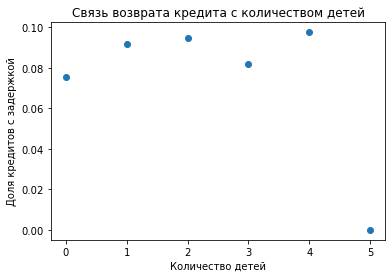

In [27]:
plt.scatter(pivot_mean(df, 'children')['children'], pivot_mean(df, 'children')['% problems'])
plt.title('Связь возврата кредита с количеством детей')
plt.xlabel('Количество детей')
plt.ylabel('Доля кредитов с задержкой')
plt.show()

**Вывод**

Прямой однозначной зависимости нет. Но если проигнорировать выбросы (люди с 5 и 3 детьми), то проглядывается тенденция - чем больше детей, тем больше трудностей с возвратом кредита. 

#### Есть ли зависимость между семейным положением и возвратом кредита в срок?

Аналогично создадим сводную таблицу и построим график.

In [28]:
display(pivot_mean(df, 'family_status').style.format({'% problems': '{:.2%}'}).background_gradient(cmap='Reds',subset='% problems'))

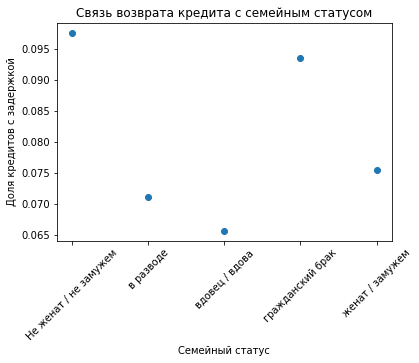

In [29]:
plt.scatter(pivot_mean(df, 'family_status')['family_status'], pivot_mean(df, 'family_status')['% problems'])
plt.title('Связь возврата кредита с семейным статусом')
plt.xlabel('Семейный статус') 
plt.ylabel('Доля кредитов с задержкой')
plt.xticks(rotation=45)
plt.show()

**Вывод**

Некоторая зависимость есть - проглядывается некоторый рост ответственности заемщика на его жизненном пути. У холостых задолженностей больше, чем у людей в гражданском браке. После сожительства следует брак, развод и вдовство. Возможно, эта зависимость косвенная - умирают партнеры у людей более старшего возраста, а холостяки моложе - и более халатно относятся к обязательствам.

#### Есть ли зависимость между возрастом заемщика и возвратом кредита в срок?

Аналогично создадим сводную таблицу и построим график.

In [30]:
display(pivot_mean(df, 'dob_years').head().style.format({'% problems': '{:.2%}'}).background_gradient(cmap='Reds',subset='% problems'))

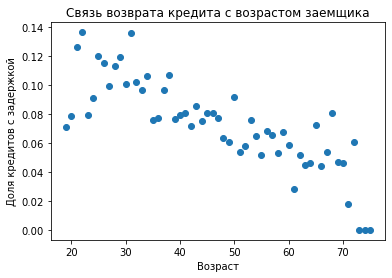

In [31]:
plt.scatter(pivot_mean(df, 'dob_years')['dob_years'], pivot_mean(df, 'dob_years')['% problems']) # построим график
plt.title('Связь возврата кредита с возрастом заемщика')
plt.xlabel('Возраст') 
plt.ylabel('Доля кредитов с задержкой')
plt.show()

**Вывод**

В целом, есть тенденция - чем старше заемщик, тем меньше проблем с возвратом. 

#### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Разделим заемщиков на когорты в зависимости от величины дохода:
- 0–50000 — `E`;
- 50001–100000 — `D`;
- 100001–300000 — `C`;
- 300001–1000000 — `B`;
- 1000001 и выше — `A`.

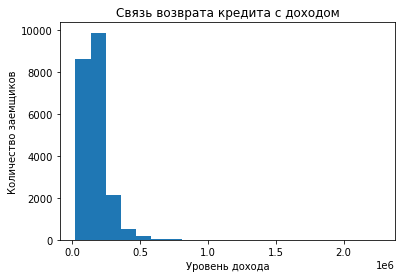

In [32]:
# то же самое картинкой
plt.hist(df['total_income'], bins=20)
plt.title('Связь возврата кредита с доходом')
plt.xlabel('Уровень дохода')
plt.ylabel('Количество заемщиков')
plt.show()

In [33]:
df['income_group'] = pd.cut(df['total_income'], bins=[0, 50000, 100000, 500000, 1000000, 3000000], labels=['E', 'D', 'C', 'B', 'A'])

df.head() # посмотрим, что получилось

children  days_employed  dob_years education  education_id  \
0         1           8437         42    высшее             0   
1         1           4024         36   среднее             1   
2         0           5623         33   среднее             1   
3         3           4124         32   среднее             1   
4         0          14177         53   среднее             1   

      family_status  family_status_id gender income_type  debt  total_income  \
0   женат / замужем                 0      F   сотрудник     0        253875   
1   женат / замужем                 0      F   сотрудник     0        112080   
2   женат / замужем                 0      M   сотрудник     0        145885   
3   женат / замужем                 0      M   сотрудник     0        267628   
4  гражданский брак                 1      F   пенсионер     0        158616   

                      purpose            purpose_stemmed  \
0               покупка жилья              [покупк, жил]   
1     приобретение автомобиля    [приобретен, автомобил]   
2               покупка жилья              [покупк, жил]   
3  дополнительное образование  [дополнительн, образован]   
4             сыграть свадьбу            [сыгра, свадьб]   

                       purpose_id income_group  
0  операции с жилой недвижимостью            C  
1          операции с автомобилем            C  
2  операции с жилой недвижимостью            C  
3           получение образования            C  
4              проведение свадьбы            C

In [34]:
df_income = pivot_mean(df, 'income_group').sort_values('income_group', ascending=False)
display(df_income.style.format({'% problems': '{:.2%}'}).background_gradient(cmap='Reds',subset='% problems'))

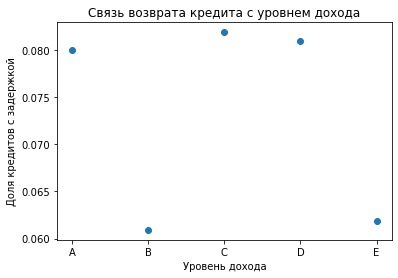

In [35]:
# построим график
plt.scatter(df_income.income_group, df_income['% problems'])
plt.xlabel('Уровень дохода')
plt.ylabel('Доля кредитов с задержкой')
plt.title('Связь возврата кредита с уровнем дохода')
plt.show()

**Вывод**

Видимой зависимости между уровнем дохода и возвратом кредита нет, что совершенно контринтуитивно. Либо действительно размер дохода не влияет на выполнение заемщиком обязательств, либо в исходных данных о доходе есть ошибки, например, перемешаны сведения о доходах за месяц и год, или отличаются валюты. 

#### Как разные цели кредита влияют на его возврат в срок?

Аналогично создадим сводную таблицу и построим график.

In [36]:
display(pivot_mean(df, 'purpose_id').style.format({'% problems': '{:.2%}'}).background_gradient(cmap='Reds',subset='% problems'))

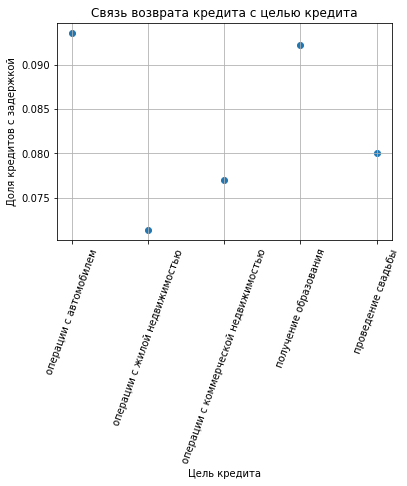

In [37]:
plt.scatter(pivot_mean(df, 'purpose_id')['purpose_id'], pivot_mean(df, 'purpose_id')['% problems']) # построим график
plt.xlabel('Цель кредита')
plt.ylabel('Доля кредитов с задержкой')
plt.title('Связь возврата кредита с целью кредита')
plt.grid()
plt.xticks(rotation=70)
plt.show()

**Вывод**

Меньше всего задержек по кредитам на жилую недвижимость, больше всего - на образование и автомобили. 

In [38]:
# а что если есть зависимость цели кредита от дохода?
df_purpose_income = df.pivot_table(index=['purpose_id','income_group'], 
                            values='debt', 
                            aggfunc=['sum', 'count', 'mean']).sort_values(by=['income_group','purpose_id'], ascending=[False, False]).reset_index()
df_purpose_income = df_purpose_income.set_axis(['purpose_id', 'income_group', 'problems_debt', 'total_debt', '% problems'], axis='columns')
display(df_purpose_income.style.format({'% problems': '{:.3%}'}).background_gradient(cmap='Reds',subset='% problems'))

- Таблица хорошо отражает, как небольшая выборка может повлиять на результат в процентах - в группе А в целом меньше всего кредитов и каждый невозврат (хотя их всего два) роняет статистику группы
- в группе B количество взятых кредитов побольше, средняя доля невозвратов самая низкая
- в группах С и D самое большое количество кредитов и доля невозвратов похожая, около 8% в среднем, причем хуже всего дела с кредитами на образование
- в самой малообеспеченной группе Е кредитов на порядок меньше, чем в соседней группе D. Видимо, получить кредит при низком доходе затруднительно. При этом по доля проблмных среди них не так уж велика - кредиты на образование и коммерческую недвижимость не возвращают менее, чем в 3% случаев, на жилую недвижимость - в 5,1%. Похуже дела со свадьбами и автомобилями - почти 8% и 13.5% соответственно. 

## Общий вывод

В ходе работы была проведена предобработка данных - устранены пропуски, некорректные значения, неявные дубликаты. Часть из них предположительно была ошибками ввода, часть - некорректно собранными или обработанными данными анкет. <br>

В дальнейшем при сборе данных стоит попытаться унифицировать получаемые значения, а также починить сбор данных о стаже заемщика - сейчас они собираются двумя разными, но одинаково неправильными способами. Подозрения вызывает также и исходные данные о доходах заемщиков - так как зависимости между задержками и уровнем дохода найти не удалось, интуитивно кажется правильным перепроверить, все ли значения даны как доход за один и тот же период и в одной и той же валюте.

Цели получния кредитов были разбиты на укрупненные категории с помощью стемминга. <br>
Были проанализованы зависимости между данными о заемщике и возвратом кредита в срок. <br>

Как ни странно, напрямую на погашение кредита в срок не влияет ни семейное положение, ни уровень дохода. Есть небольшая корреляция с количеством детей и с возрастом заемщиков. <br>
Чаще всего возвращают в срок кредиты на собственное жилье, а больше всего задержек по кредитам на автомобили и образование. 